### **Exploring the Efficacy of Latent Dirichlet Allocation and BERTopic for Topic Modeling in Optimizing English-Filipino ASR-Derived Speech Content Analysis**  

FLORA, Jane Frances Ma. Vianney P.  
TALAVERA, Joanna Elaine J.  

**CHAPTER III - METHODS | CODE IMPLEMENTATION**



### Installing Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Installing dependecies

# !pip install gensim
!pip install bertopic
# !pip install scikit-learn
# !pip install tqdm
# !pip install transformers
# !pip install numpy pandas matplotlib seaborn
!pip install jiwer
!pip install Datasets
!pip install nltk

# For podcast transcription

# !pip install whisper

In [ ]:
# Importing Dependencies

import gensim
from bertopic import BERTopic
import sklearn
import tqdm
import transformers
import jiwer
import datasets
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from scipy.sparse import issparse
import torch
from gensim import corpora
from transformers import pipeline

# Miscellaneous Dependencies

import os
import glob
import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Download NLTK resources

import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
from gensim import corpora

# For visualization

import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### The Dataset  

In [ ]:
# Define your directories
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Initialize an empty list to store the documents
data = []

In [ ]:
# Loop through each directory and read text files
for directory in directories:
    # Get all text files in the current directory
    text_files = glob.glob(os.path.join(directory, '*.txt'))

    # Read each text file and append its content to the data list
    for file_path in text_files:
        with open(file_path, 'r') as file:
            content = file.read()
            data.append(content)

In [ ]:
# Print the number of documents loaded
num_documents = len(data)
print(f"Number of documents: {num_documents}")

Number of documents: 21


In [ ]:
# Assuming 'data' contains the loaded documents
first_document = data[0]

# Tokenize the document into sentences
sentences = nltk.sent_tokenize(first_document)

# Display the first 5 sentences
for i, sentence in enumerate(sentences[:5]):
    print(f"Sentence {i+1}:\n{sentence}\n")

Sentence 1:
Hmm.

Sentence 2:
Hello everyone!

Sentence 3:
Ang ganda ng topic natin ngayon, no?

Sentence 4:
Bakit nga ba mahirap mahalin ang sarili?

Sentence 5:
Bakit ba?



In [ ]:
# Function to calculate total words and characters
def calculate_corpus_statistics(documents):
    total_words = 0
    total_characters = 0
    for doc in documents:
        total_words += len(doc.split())
        total_characters += len(doc)
    return total_words, total_characters

In [ ]:
# Calculate and display corpus quantities
total_words, total_characters = calculate_corpus_statistics(data)
print(f"Total number of words: {total_words}")
print(f"Total number of characters: {total_characters}")

Total number of words: 56377
Total number of characters: 318311


### Text Preprocessing


In [ ]:
# Define English stopwords
english_stopwords = set(stopwords.words('english'))

# Load Tagalog stopwords from file
tagalog_stopwords_file = "/content/drive/MyDrive/Thesis Data/stopwords-tl.txt"
with open(tagalog_stopwords_file, 'r') as f:
    tagalog_stopwords = set(f.read().splitlines())

# Combine English and Tagalog stopwords
all_stopwords = english_stopwords.union(tagalog_stopwords)

In [ ]:
print(all_stopwords)

{'', 'couldn', 'doon', "hasn't", "you're", 'here', 'katulad', 'during', 'siya', 'mightn', 'ako', 'yourselves', 'ba', "mustn't", 'dapat', 'may', 'pero', 'pababa', 'before', 'mula', 'tayo', 'sabi', 'talaga', 'she', 'ilagay', 'saka', 'alin', 'gayunman', 'theirs', 'herself', 'an', 'he', 'him', 'marami', 'si', 'ayun', 'your', 'namin', 'hadn', 'mo', 'po', 'if', "won't", 'own', 'kumuha', 'aren', 'over', 'myself', 'few', 'can', 'Ayun', 'mahusay', "isn't", 'oo', 'nito', 'sila', 'itself', 'ibabaw', 'katiyakan', 'maging', 'lamang', 'did', 'because', 'pa', 'mayroon', "weren't", 'into', 'naman', 'been', 'sabihin', 'ginagawa', 'ma ', 'iyon', 'kaya', 'nyo', 'not', 'ninyo', 'lahat', "should've", 'y', 'our', 'ain', 'laban', 'ito', 'ni', 'off', 'apat', 'had', 'for', 'ang', 'lima', 'maaaring', 'out', 'ibig', 'a', 'or', 'inyong', 'once', 'pagitan', 'ilan', 'didn', 'the', 'yung', 'ay', 'ikaw', 'kong', 'these', 'tapos', 'hasn', 'likod', "you'd", 'don', 'pangalawa', 'aming', 'parang', 'at', 'from', 'ko', 'm'

In [ ]:
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ensure NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
stopwords = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define directories for text files
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Read and combine text files from directories into one corpus
def read_combine_files(directories):
    corpus = []
    for directory in directories:
        files = os.listdir(directory)
        for file in files:
            file_path = os.path.join(directory, file)
            with open(file_path, 'r') as f:
                text = f.read()
                corpus.append(text)
    return corpus

# Function to preprocess a single document
def preprocess_document(document):
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
    # Tokenize the text
    words = word_tokenize(cleaned_text)
    # Remove stopwords
    filtered_words = [word for word in words if word not in all_stopwords]
    # Lemmatize the words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    # Join lemmatized words back into a string
    processed_text = ' '.join(lemmatized_words)
    return processed_text

# Preprocess the corpus by removing stopwords and lemmatizing
def preprocess_corpus(corpus):
    processed_corpus = [preprocess_document(doc) for doc in corpus]
    return processed_corpus

# Read and combine text files from directories into corpus
corpus = read_combine_files(directories)

# Preprocess the corpus
processed_corpus = preprocess_corpus(corpus)

# Print an example of processed document
print(processed_corpus[0])  # Print the first processed document to verify

# Tokenize the processed corpus
tokens = [doc.split() for doc in processed_corpus]

# Print an example of tokens
print(tokens[0])  # Print tokens of the first document to verify

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


hmm hello everyone ganda topic mahirap mahalin totoo mahirapan mahalin mahalin mere fact nandito nagiexist kamahalmahal ganon mahirap mahalin welcome mind buddy millennial psychologist rian portuguese service siyempre siyempre nagtanong nung nakaraan mahirap mahalin ifeature listener napakainteresting sagot naghalohalo tema siyempre imemention tema nakuha audience alam makakarelate maiba tema sagot kinalaman condition worth maiba pagbibigay atensyon maiba pagkafroy desire namang kinalaman pagkukumpara simulan meron talagang naganswer mahirap daw mahalin keji dinedepende worth standard mahirap habulin ideal sineset naisip order worthy must please people feed ego mahal feel worthy nagsastart pagmamahal well fact first place validation love desire must came alam katotohanan sinabi time akala talagang mahal alam source love nagagaling ibang tao teka wala namang masama source love nagagaling ibang tao psychology fact pinaguusapan teorya mahalaga mabuild foundation love trust pang essential 

In [ ]:
documents = [' '.join(doc) for doc in tokens]

In [ ]:
print(documents)

['hmm hello everyone ganda topic mahirap mahalin totoo mahirapan mahalin mahalin mere fact nandito nagiexist kamahalmahal ganon mahirap mahalin welcome mind buddy millennial psychologist rian portuguese service siyempre siyempre nagtanong nung nakaraan mahirap mahalin ifeature listener napakainteresting sagot naghalohalo tema siyempre imemention tema nakuha audience alam makakarelate maiba tema sagot kinalaman condition worth maiba pagbibigay atensyon maiba pagkafroy desire namang kinalaman pagkukumpara simulan meron talagang naganswer mahirap daw mahalin keji dinedepende worth standard mahirap habulin ideal sineset naisip order worthy must please people feed ego mahal feel worthy nagsastart pagmamahal well fact first place validation love desire must came alam katotohanan sinabi time akala talagang mahal alam source love nagagaling ibang tao teka wala namang masama source love nagagaling ibang tao psychology fact pinaguusapan teorya mahalaga mabuild foundation love trust pang essentia

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


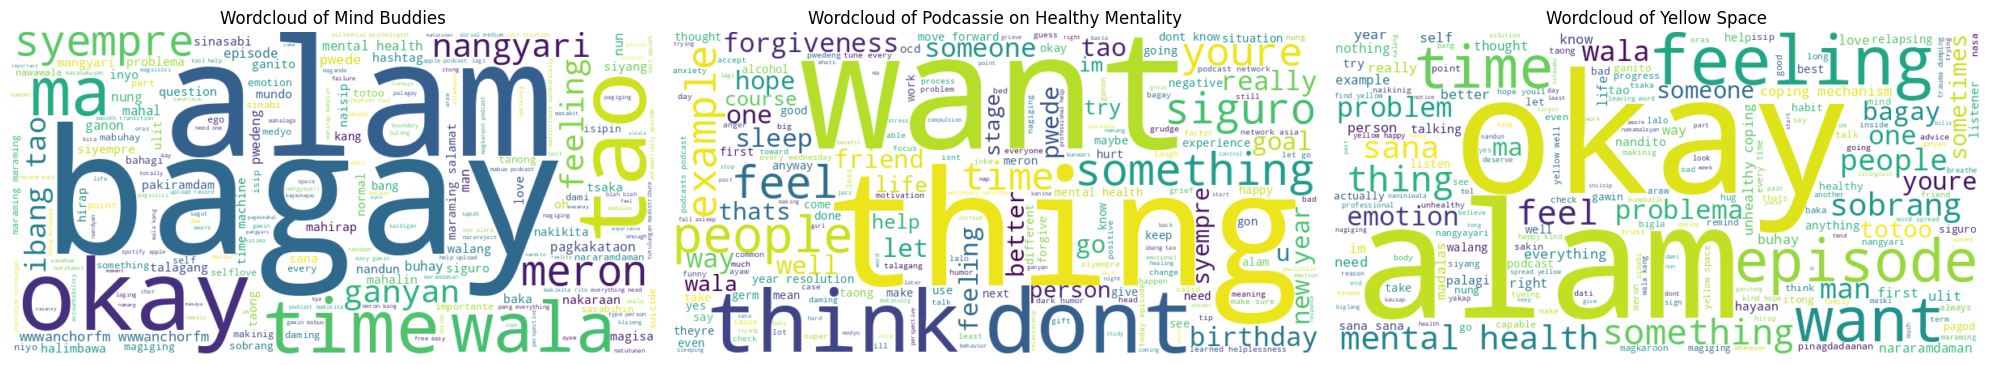

In [ ]:
# VISUALIZATION | CREATING WORDCLOUD

#!pip install nltk wordcloud
import os
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Define directories for text files
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Define English stopwords
english_stopwords = set(stopwords.words('english'))

# Load Tagalog stopwords from file
tagalog_stopwords_file = "/content/drive/MyDrive/Thesis Data/stopwords-tl.txt"
with open(tagalog_stopwords_file, 'r') as f:
    tagalog_stopwords = set(f.read().splitlines())

# Combine English and Tagalog stopwords
all_stopwords = english_stopwords.union(tagalog_stopwords)

# Function to read files from a directory
def read_files_from_directory(directory):
    corpus = []
    for file in sorted(os.listdir(directory)):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            text = f.read()
            corpus.append(text)
    return corpus

# Function to lemmatize words
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word) for word in words]
    return lemma_words

# Function to preprocess the corpus
def preprocess_corpus(corpus, stopwords):
    processed_corpus = []
    for document in corpus:
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
        words = word_tokenize(cleaned_text)
        filtered_words = [word for word in words if word not in stopwords]
        lemmatized_words = lemmatize_words(filtered_words)
        processed_text = ' '.join(lemmatized_words)
        processed_corpus.append(processed_text)
    return processed_corpus

# Function to generate and display a word cloud
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Read, preprocess and combine text for each podcast show
podcast_titles = ["Mind Buddies", "Podcassie on Healthy Mentality", "Yellow Space"]
combined_texts = []

for directory in directories:
    # Read files
    corpus = read_files_from_directory(directory)

    # Preprocess corpus
    processed_corpus = preprocess_corpus(corpus, all_stopwords)

    # Combine all episodes into one text
    combined_text = ' '.join(processed_corpus)
    combined_texts.append(combined_text)

# Generate and display word clouds for each podcast show in subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 10))
for i, combined_text in enumerate(combined_texts):
    title = f"Wordcloud of {podcast_titles[i]}"
    generate_wordcloud(combined_text, title, axes[i])

plt.tight_layout()
plt.show()

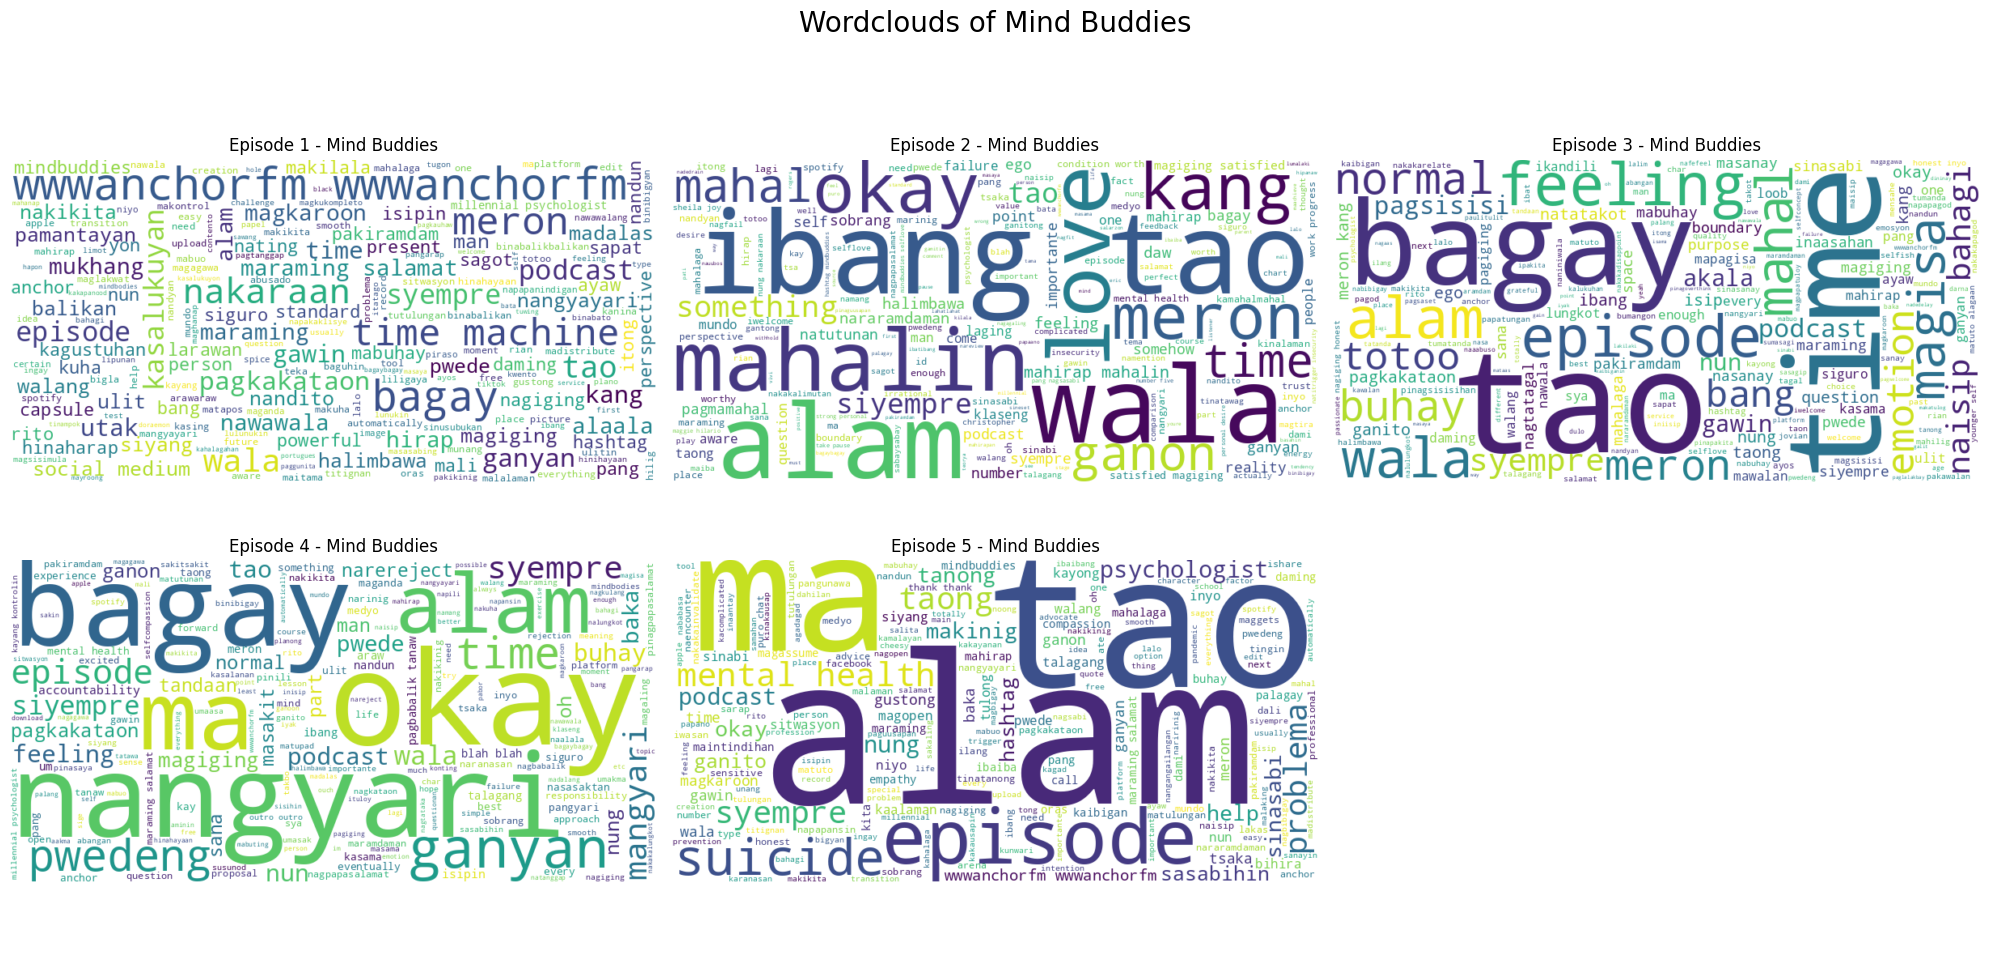

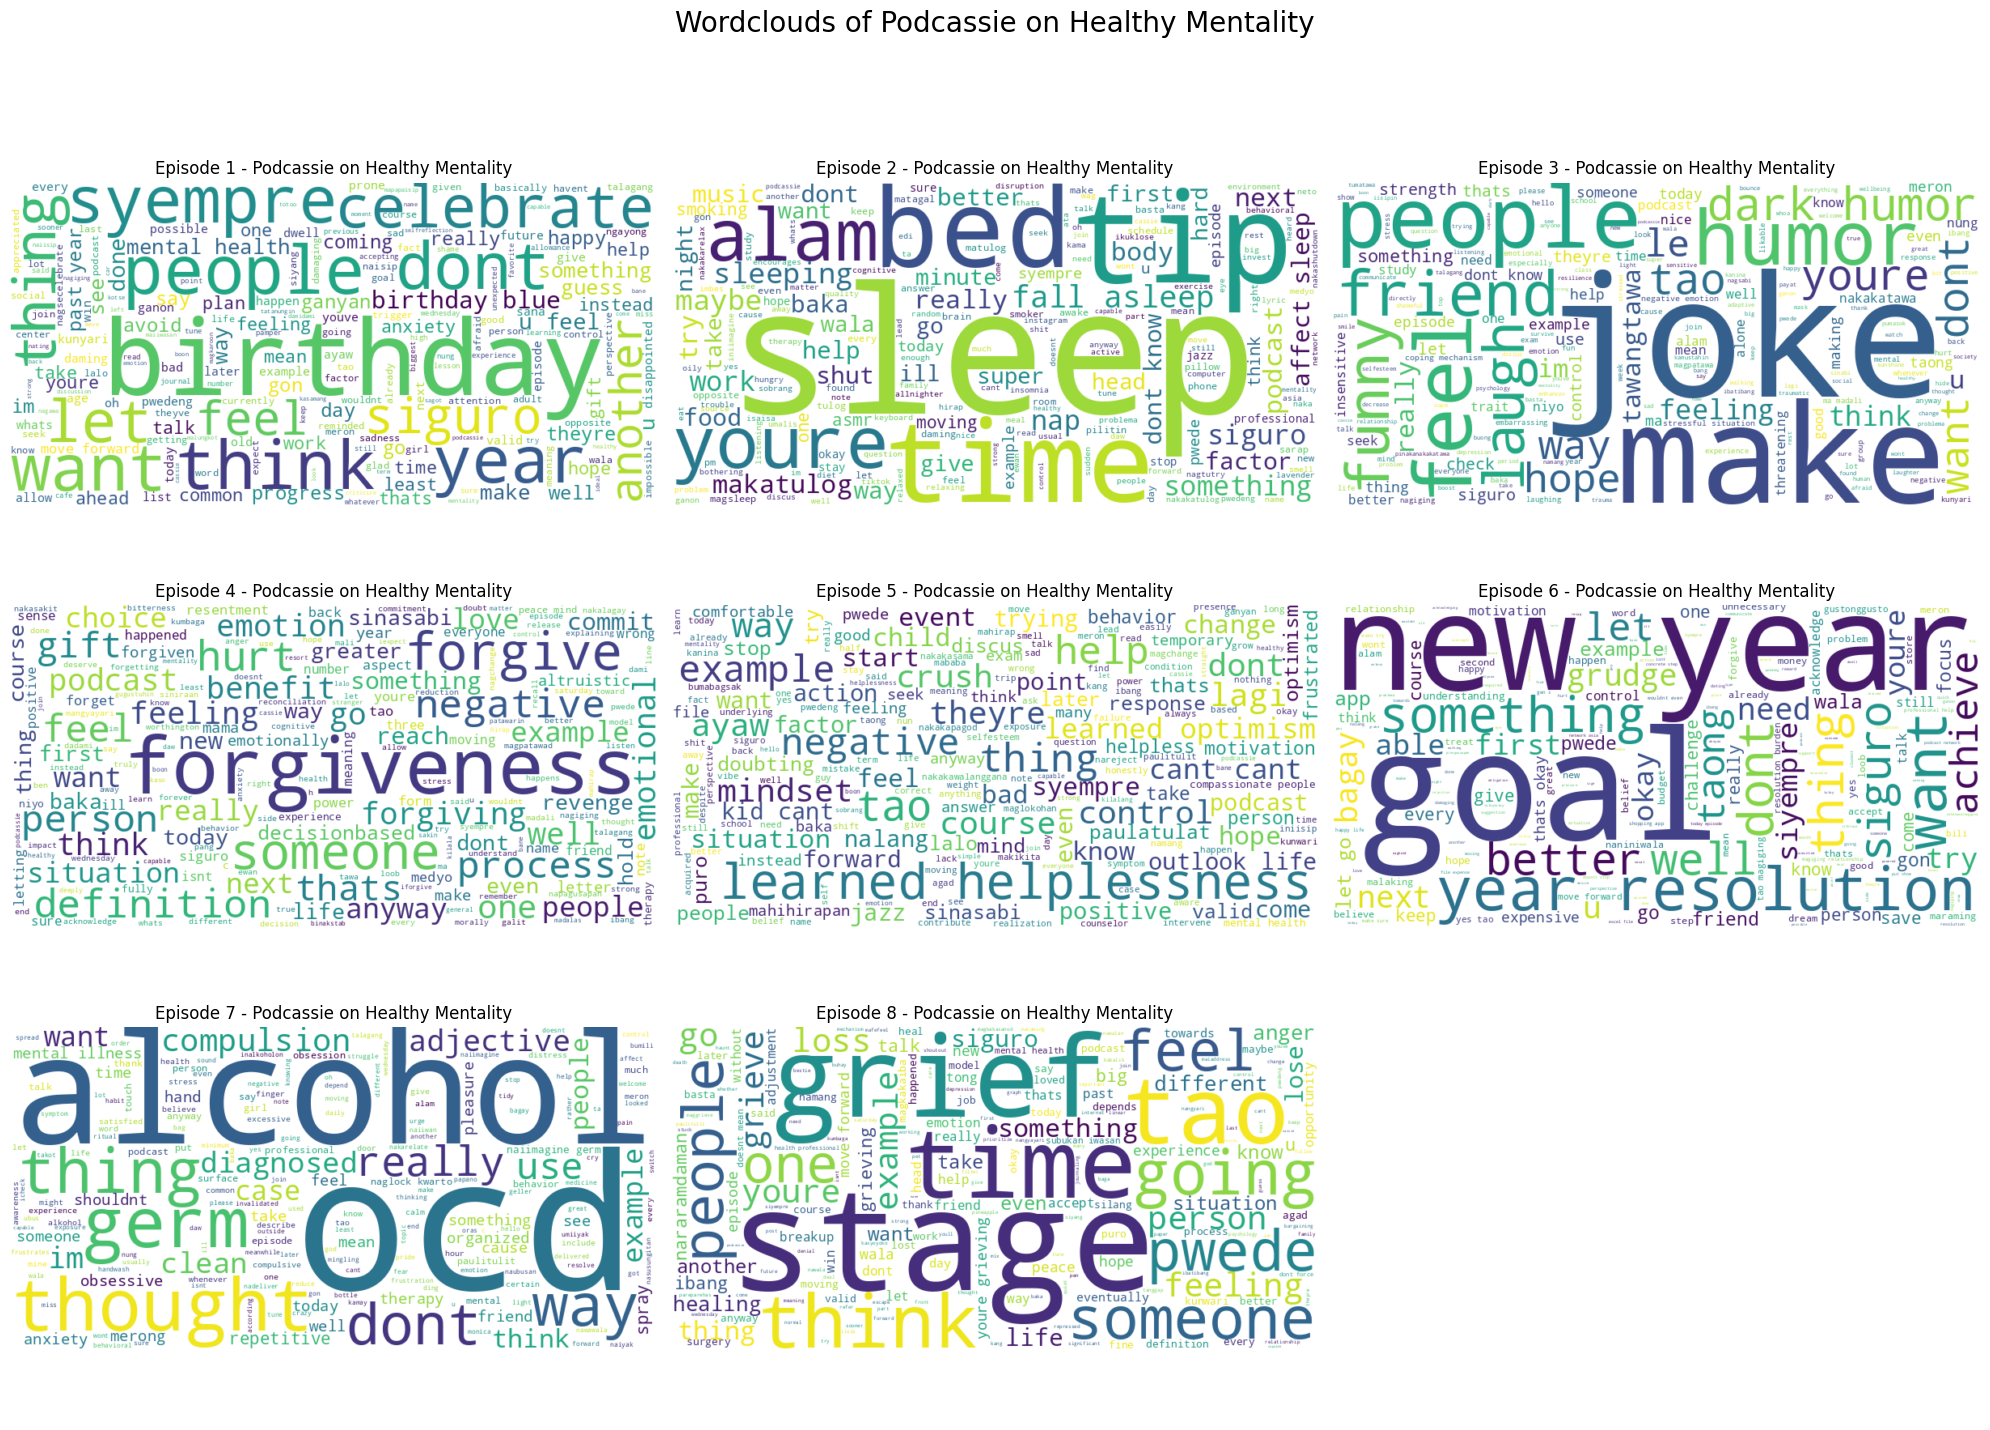

In [ ]:
# Define directories for text files
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Define English stopwords
english_stopwords = set(stopwords.words('english'))

# Load Tagalog stopwords from file
tagalog_stopwords_file = "/content/drive/MyDrive/Thesis Data/stopwords-tl.txt"
with open(tagalog_stopwords_file, 'r') as f:
    tagalog_stopwords = set(f.read().splitlines())

# Combine English and Tagalog stopwords
all_stopwords = english_stopwords.union(tagalog_stopwords)

# Function to read files from a directory
def read_files_from_directory(directory):
    corpus = []
    for file in sorted(os.listdir(directory)):
        file_path = os.path.join(directory, file)
        with open(file_path, 'r') as f:
            text = f.read()
            corpus.append(text)
    return corpus

# Function to lemmatize words
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word) for word in words]
    return lemma_words

# Function to preprocess the corpus
def preprocess_corpus(corpus, stopwords):
    processed_corpus = []
    for document in corpus:
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
        words = word_tokenize(cleaned_text)
        filtered_words = [word for word in words if word not in stopwords]
        lemmatized_words = lemmatize_words(filtered_words)
        processed_text = ' '.join(lemmatized_words)
        processed_corpus.append(processed_text)
    return processed_corpus

# Function to generate and display a word cloud
def generate_wordcloud(text, title, ax):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title)
    ax.axis('off')

# Read, preprocess and generate word cloud for each episode in each directory
for directory, podcast_title in zip(directories, ["Mind Buddies", "Podcassie on Healthy Mentality", "Yellow Space"]):
    # Read files
    corpus = read_files_from_directory(directory)

    # Preprocess corpus
    processed_corpus = preprocess_corpus(corpus, all_stopwords)

    # Determine subplot layout
    num_episodes = len(processed_corpus)
    ncols = 3
    nrows = (num_episodes // ncols) + (num_episodes % ncols > 0)

    fig, axes = plt.subplots(nrows, ncols, figsize=(20, nrows * 5))

    # Generate word cloud for each episode
    for i, episode in enumerate(processed_corpus):
        row, col = divmod(i, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]
        title = f"Episode {i + 1} - {podcast_title}"
        generate_wordcloud(episode, title, ax)

    # Hide any empty subplots
    for j in range(num_episodes, nrows * ncols):
        row, col = divmod(j, ncols)
        ax = axes[row, col] if nrows > 1 else axes[col]
        ax.axis('off')

    plt.suptitle(f"Wordclouds of {podcast_title}", fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [ ]:
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim import corpora

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Define directories for text files
directories = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Read and combine text files from directories into one corpus
def read_combine_files(directories):
    corpus = []
    for directory in directories:
        files = os.listdir(directory)
        for file in files:
            file_path = os.path.join(directory, file)
            with open(file_path, 'r', encoding='utf-8') as f:
                text = f.read()
                corpus.append(text)
    return corpus

# Function to lemmatize words
def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in words]

# Preprocess the corpus by removing stopwords and lemmatizing
def preprocess_corpus(corpus, stopwords):
    processed_corpus = []
    for document in corpus:
        cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
        words = word_tokenize(cleaned_text)
        filtered_words = [word for word in words if word not in stopwords]
        lemmatized_words = lemmatize_words(filtered_words)
        processed_corpus.append(lemmatized_words)  # Changed to append list of words
    return processed_corpus

# Read and combine text files from directories into corpus
corpus = read_combine_files(directories)

# Define stopwords in English and Tagalog
english_stopwords = set(stopwords.words('english'))
tagalog_stopwords = set(tagalog_stopwords)
all_stopwords = english_stopwords.union(tagalog_stopwords)

# Preprocess the corpus by removing stopwords
processed_corpus = preprocess_corpus(corpus, all_stopwords)

# Print the first few processed documents to verify
print(processed_corpus[:2])

# Create a dictionary from the tokenized corpus
dictionary = corpora.Dictionary(processed_corpus)

# Create a bag-of-words representation of the corpus
corpus_bow = [dictionary.doc2bow(document) for document in processed_corpus]

# Ensure that corpus_bow contains 21 documents
print(f'Number of documents in corpus_bow: {len(corpus_bow)}')

# Check the first document's bag-of-words representation
print(corpus_bow[0])

In [ ]:
print("Type of corpus (BoW matrix):", type(processed_corpus))
print("Type of BoW for the first document:", type(tokens))
print("Type of a document:", type(corpus_bow))
print("Type of a Dictionary:", type(dictionary))

#### LDA

In [ ]:
# Check the number of documents
num_docs = len(corpus_bow)
print(f'Number of documents in corpus: {num_docs}')

In [ ]:
import numpy as np
from gensim.models import LdaModel
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# Assuming corpus_bow and dictionary are already defined
num_topics = 10
num_folds = 3
num_epochs = 10
num_passes_per_epoch = 5  # Set the number of passes per epoch

kf = KFold(n_splits=num_folds, shuffle=True, random_state=10)

perplexity_scores = np.zeros((num_folds, num_epochs))

for fold, (train_index, val_index) in enumerate(kf.split(corpus_bow)):
    train_corpus = [corpus_bow[i] for i in train_index]
    val_corpus = [corpus_bow[i] for i in val_index]

    lda_model = LdaModel(corpus=train_corpus, id2word=dictionary, num_topics=num_topics, random_state=10, passes=1)

    for epoch in range(num_epochs):
        lda_model.update(train_corpus, passes=num_passes_per_epoch)  # Increase the number of passes
        perplexity = lda_model.log_perplexity(val_corpus)
        perplexity_scores[fold, epoch] = perplexity
        print(f'Fold: {fold+1}, Epoch: {epoch+1}, Passes: {num_passes_per_epoch}, Perplexity: {perplexity}')

# Visualization
mean_perplexity = np.mean(perplexity_scores, axis=0)
std_perplexity = np.std(perplexity_scores, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_perplexity, label='Mean Perplexity')
plt.fill_between(range(1, num_epochs + 1),
                 mean_perplexity - std_perplexity,
                 mean_perplexity + std_perplexity,
                 color='b', alpha=0.2, label='Std Deviation')

plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('LDA Model Perplexity Across Epochs and Folds')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Visualize perplexity for each fold separately
plt.figure(figsize=(12, 8))

for fold in range(num_folds):
    plt.subplot(num_folds, 1, fold+1)
    plt.plot(range(1, num_epochs + 1), perplexity_scores[fold], marker='o', linestyle='-', label=f'Fold {fold+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Perplexity')
    plt.title(f'LDA Model Perplexity - Fold {fold+1}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# COHERENCE SCORE CALCULATION

from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_corpus, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()

print(f'Coherence Score: {coherence_score}')

In [ ]:
# TOPIC FREQUENCY
for idx, topic in lda_model.print_topics(-1):
    print(f'Topic: {idx}\nWords: {topic}\n')

In [ ]:
# MOST UNIQUE WORDS PER TOPIC

topic_weights = lda_model.get_topics()
topic_df = pd.DataFrame(topic_weights).T

topic_word_matrix = lda_model.get_topics()
topic_word_matrix_list = topic_word_matrix.tolist()

# Dictionary to track the words that have already been selected
selected_words = set()

if isinstance(topic_word_matrix_list, list):
    print("Topic-Word Matrix (showing top 5 unique words per topic):")
    for i, topic in enumerate(topic_word_matrix_list):
        if not topic:
            print(f"Topic {i+1}: (no words)")
        else:
            sorted_word_weights = sorted(enumerate(topic), key=lambda x: x[1], reverse=True)
            unique_words = []

            for word_id, weight in sorted_word_weights:
                word = dictionary[word_id]
                if word not in selected_words:
                    unique_words.append((word, weight))
                    selected_words.add(word)

                if len(unique_words) >= 5:
                    break

            print(f"Topic {i+1}:")
            for word, weight in unique_words:
                print(f"\t- {word}: {weight:.4f}")
        print("")
else:
    print("topic_word_matrix is not a list. Investigate why the model is returning a scalar value.")

results = []

if isinstance(topic_word_matrix_list, list):
    for i, topic in enumerate(topic_word_matrix_list):
        if not topic:
            results.append([f"Topic {i+1}", "(no words)", ""])
        else:
            sorted_word_weights = sorted(enumerate(topic), key=lambda x: x[1], reverse=True)
            unique_words = []
            for word_id, weight in sorted_word_weights:
                word = dictionary[word_id]
                if word not in selected_words:
                    unique_words.append((word, weight))
                    selected_words.add(word)
                if len(unique_words) >= 5:
                    break
            for word, weight in unique_words:
                results.append([f"Topic {i+1}", word, weight])


results_df = pd.DataFrame(results, columns=["Topic", "Word", "Weight"])
results_df

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary

# Ensure the previous steps are executed (corpus, dictionary, lda_model creation, etc.)

# Get the topic-word matrix
topic_word_matrix = lda_model.get_topics()

# Check the type and contents of topic_word_matrix
print(type(topic_word_matrix))

# Dictionary to track the words that have already been selected
selected_words = set()

# Check if topic_word_matrix is a numpy array (as expected)
if isinstance(topic_word_matrix, np.ndarray):
    print("Topic-Word Matrix (showing top 5 unique words per topic):")
    results = []
    for i, topic in enumerate(topic_word_matrix):
        sorted_word_weights = sorted(enumerate(topic), key=lambda x: x[1], reverse=True)
        unique_words = []

        for word_id, weight in sorted_word_weights:
            word = dictionary[word_id]
            if word not in selected_words:
                unique_words.append((word, weight))
                selected_words.add(word)

            if len(unique_words) >= 5:
                break

        print(f"Topic {i + 1}:")
        for word, weight in unique_words:
            print(f"\t- {word}: {weight:.4f}")
            results.append([f"Topic {i + 1}", word, weight])
        print("")
else:
    print("topic_word_matrix is not a numpy array. Investigate why the model is returning a scalar value.")

In [ ]:
# Assuming lda_model is your trained LDA model

# Get the top words and their probabilities for each topic
topics = lda_model.show_topics(formatted=False)

# topics is a list of tuples (topic_number, [(word, probability), ...])
# Extracting top words and probabilities for visualization
top_words = [(topic_num, [(word, prob) for word, prob in lda_words]) for topic_num, lda_words in topics]

In [ ]:
import matplotlib.pyplot as plt

# Function to plot top words for a single topic
def plot_topic_words(topic_num, top_words):
    words = [word for word, prob in top_words]
    probs = [prob for word, prob in top_words]

    plt.figure(figsize=(10, 6))
    plt.bar(words, probs, color='blue', alpha=0.7)
    plt.xlabel('Words')
    plt.ylabel('Probabilities')
    plt.title(f'Top Words for Topic {topic_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot top words for each topic
for topic_num, words_probs in top_words:
    plot_topic_words(topic_num, words_probs)

#### BERTopic

In [ ]:
# Join tokens back into documents
documents = [' '.join(doc) for doc in tokens]

In [ ]:
# Initialize BERTopic model components and parameters
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, min_samples=5, gen_min_span_tree=True)

# Building the BERTopic model
model = BERTopic(embedding_model=embedding_model,
                 umap_model=umap_model,
                 hdbscan_model=hdbscan_model,
                 top_n_words=5,
                 calculate_probabilities=True,
                 verbose=True)

In [ ]:
num_folds = 3  # Number of folds
num_epochs = 10  # Number of epochs per fold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=10)

# Store coherence scores
coherence_scores = np.zeros((num_folds, num_epochs))

In [ ]:
print(coherence_scores)

In [ ]:
for fold, (train_index, val_index) in enumerate(kf.split(documents)):
    train_data = [documents[i] for i in train_index]
    val_data = [documents[i] for i in val_index]

    # Remove empty documents to avoid empty vocabulary error
    train_data = [doc for doc in train_data if doc.strip()]
    val_data = [doc for doc in val_data if doc.strip()]

    if len(val_data) >= hdbscan_model.min_samples:
        for epoch in range(num_epochs):
            # Fit BERTopic model with train data
            topics, _ = model.fit_transform(train_data)

            # Fit HDBSCAN separately after UMAP transformation
            umap_embeddings = model.umap_model.transform(model.embedding_model.embed(val_data))
            hdbscan_model.fit(umap_embeddings)  # Fit HDBSCAN here

            # Transform validation data with BERTopic, avoid calculating probabilities
            val_topics, _ = model.transform(val_data)

            # Get topic representations for validation data
            val_topic_representations = model.get_topic_info()

            # Create Gensim dictionary from validation data
            val_data_tokenized = [tokens[i] for i in val_index]
            dictionary = corpora.Dictionary(val_data_tokenized)

            # Get topic coherence, handle potential -1 (noise topic)
            valid_topic_indices = [i for i in range(len(set(val_topics))) if i != -1]
            if valid_topic_indices:
                coherence_model = CoherenceModel(
                    topics=[model.get_topic(i) for i in valid_topic_indices],
                    texts=val_data_tokenized,
                    dictionary=dictionary,
                    coherence='c_v'
                )
                coherence = coherence_model.get_coherence()

                coherence_scores[fold, epoch] = coherence

                print(f'Fold: {fold+1}, Epoch: {epoch+1}, Coherence: {coherence}')
            else:
                print(f'Fold: {fold+1}, Epoch: {epoch+1}, No valid topics found in validation set')
    else:
        print(f'Fold: {fold+1}, not enough validation data for HDBSCAN')

# Visualization of Coherence Scores
mean_coherence = np.mean(coherence_scores, axis=0)
std_coherence = np.std(coherence_scores, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_coherence, label='Mean Coherence')
plt.fill_between(range(1, num_epochs + 1),
                 mean_coherence - std_coherence,
                 mean_coherence + std_coherence,
                 color='b', alpha=0.2, label='Std Deviation')

plt.xlabel('Epochs')
plt.ylabel('Coherence')
plt.title('BERTopic Model Coherence Across Epochs and Folds')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora

# Check for CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# KFold Cross-Validation
num_folds = 5
num_epochs = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=10)

# Store coherence scores
coherence_scores = np.zeros((num_folds, num_epochs))

# Function to convert tokenized documents back to strings for BERTopic
def join_tokens(tokens):
    return [' '.join(doc) for doc in tokens]

# Join tokens back into documents
documents = join_tokens(tokens)

for fold, (train_index, val_index) in enumerate(kf.split(documents)):
    train_data = [documents[i] for i in train_index]
    val_data = [documents[i] for i in val_index]
    val_data_tokenized = [tokens[i] for i in val_index]

    # Remove empty documents to avoid empty vocabulary error
    train_data = [doc for doc in train_data if doc.strip()]

    # Initialize BERTopic model with adjusted parameters
    umap_model = UMAP(init="random")  # Change initialization to avoid spectral layout
    hdbscan_model = HDBSCAN(min_cluster_size=20, min_samples=5)  # Adjust HDBSCAN parameters

    topic_model = BERTopic(
        low_memory=True,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model
    )

    for epoch in range(num_epochs):
        # Fit BERTopic model with train data
        topics, _ = topic_model.fit_transform(train_data)

        # Get topic representation for validation data
        val_topics, _ = topic_model.transform(val_data)

        # Create Gensim dictionary from validation data
        dictionary = corpora.Dictionary(val_data_tokenized)

        # Get topic coherence
        coherence_model = CoherenceModel(topics=[topic_model.get_topic(i) for i in range(len(set(val_topics)))],
                                         texts=val_data_tokenized, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()

        coherence_scores[fold, epoch] = coherence

        print(f'Fold: {fold+1}, Epoch: {epoch+1}, Coherence: {coherence}')

# Visualization
mean_coherence = np.mean(coherence_scores, axis=0)
std_coherence = np.std(coherence_scores, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_coherence, label='Mean Coherence')
plt.fill_between(range(1, num_epochs + 1),
                 mean_coherence - std_coherence,
                 mean_coherence + std_coherence,
                 color='b', alpha=0.2, label='Std Deviation')

plt.xlabel('Epochs')
plt.ylabel('Coherence')
plt.title('BERTopic Model Coherence Across Epochs and Folds')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(tokens)

In [ ]:
# Initialize BERTopic model
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# If CUDA is available, try setting the device to CPU
device = torch.device('cpu')

# Load the RoBERTa Tagalog model on the selected device
embedding_model = BERTopic()

# Initialize BERTopic with the embedding model and adjusted HDBSCAN parameters
topic_model = BERTopic(
    embedding_model=embedding_model,
    low_memory=True,
    umap_model=UMAP(init="random"),  # Change initialization to avoid spectral layout
    hdbscan_model=HDBSCAN(min_cluster_size=20, min_samples=5) # Adjust HDBSCAN parameters
)

# Assuming tokens are already defined
num_folds = 5
num_epochs = 10

# KFold Cross-Validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=10)

# Fit BERTopic model with your tokenized data
topics, probabilities = topic_model.fit_transform(tokens)

# Get topic information
topic_info = topic_model.get_topic_info()

In [ ]:
import torch
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import numpy as np
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from nltk.tokenize import word_tokenize

# Ensure CUDA is available if using GPU
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Assuming tokens are already defined
tokens = tokenize_corpus

num_folds = 5
num_epochs = 10

# KFold Cross-Validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=10)

# Store coherence scores
coherence_scores = np.zeros((num_folds, num_epochs))

for fold, (train_index, val_index) in enumerate(kf.split(tokens)):
    train_data = [tokens[i] for i in train_index]
    val_data = [tokens[i] for i in val_index]

    # Flatten the train and validation data
    train_data_flattened = [' '.join(doc) for doc in train_data]
    val_data_flattened = [' '.join(doc) for doc in val_data]

    # Initialize BERTopic model with adjusted parameters
    umap_model = UMAP(init="random")  # Change initialization to avoid spectral layout
    hdbscan_model = HDBSCAN(min_cluster_size=20, min_samples=5)  # Adjust HDBSCAN parameters

    topic_model = BERTopic(
        low_memory=True,
        umap_model=umap_model,
        hdbscan_model=hdbscan_model
    )

    for epoch in range(num_epochs):
        # Fit BERTopic model with train data
        topics, _ = topic_model.fit_transform(train_data_flattened)

        # Extract topics for validation data
        val_topics, _ = topic_model.transform(val_data_flattened)

        # Create Gensim dictionary from validation data
        val_data_tokenized = [word_tokenize(doc) for doc in val_data_flattened]
        dictionary = corpora.Dictionary(val_data_tokenized)

        # Get topic coherence
        coherence_model = CoherenceModel(topics=[topic_model.get_topic(i) for i in range(len(set(val_topics)))],
                                         texts=val_data_tokenized, dictionary=dictionary, coherence='c_v')
        coherence = coherence_model.get_coherence()

        coherence_scores[fold, epoch] = coherence

        print(f'Fold: {fold+1}, Epoch: {epoch+1}, Coherence: {coherence}')

# Visualization
mean_coherence = np.mean(coherence_scores, axis=0)
std_coherence = np.std(coherence_scores, axis=0)

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), mean_coherence, label='Mean Coherence')
plt.fill_between(range(1, num_epochs + 1),
                 mean_coherence - std_coherence,
                 mean_coherence + std_coherence,
                 color='b', alpha=0.2, label='Std Deviation')

plt.xlabel('Epochs')
plt.ylabel('Coherence')
plt.title('BERTopic Model Coherence Across Epochs and Folds')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
topic_info

In [ ]:
topic_freq = topic_model.get_topic_freq()
topic_freq

In [ ]:
# Topic Frequency | With representation labels

# Get the frequency of all topics
topic_freq = topic_model.get_topic_freq()

# Sort topics by frequency in descending order
sorted_topics = topic_freq.sort_values("Count", ascending=False)

# Print topics with at least 10 words
for index, row in sorted_topics.iterrows():
    topic_idx = row['Topic']
    count = row['Count']
    topic_words = topic_model.get_topic(topic_idx)
    if len(topic_words) >= 10:  # Check if topic has at least 10 words
        top_words = [word for word, _ in topic_words]
        print(f"Topic {topic_idx}: Count: {count}, Top words: {' '.join(top_words)}")

In [ ]:
# Assume tokens is your list of tokenized documents

# Concatenate all tokens into a single string
documents_as_string = ' '.join([' '.join(doc) for doc in tokens])

# Initialize BERTopic model
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# If CUDA is available, try setting the device to CPU
device = torch.device('cpu')

# Load the RoBERTa Tagalog model on the selected device
embedding_model = BERTopic()

# Get the maximum sequence length for the model
max_seq_length = embedding_model.max_seq_length
print(f"Maximum sequence length for the model: {max_seq_length}")

# Initialize BERTopic with the embedding model and adjusted HDBSCAN parameters
topic_model = BERTopic(
    embedding_model=embedding_model,
    low_memory=True,
    umap_model=UMAP(init="random"),  # Change initialization to avoid spectral layout
    hdbscan_model=HDBSCAN(min_cluster_size=20, min_samples=5)  # Adjust HDBSCAN parameters
)

# Fit BERTopic model with your tokenized data
try:
    topics, probabilities = topic_model.fit_transform([documents_as_string])
    print("Model successfully trained!")
except Exception as e:
    print(f"Error occurred: {str(e)}")

# Get topic information
try:
    topic_info = topic_model.get_topic_info()
    print("Topic information retrieved successfully!")
except Exception as e:
    print(f"Error occurred while getting topic info: {str(e)}")


In [ ]:
print(type(documents_as_string))

`NOTES`: Itong part na to hindi ko sure paano gagawan ng visualization kasi madami sdjfh

In [ ]:
# VISUALIZATION | TOPIC DISTANCE PLOT

import plotly.express as px

# Reduce dimensionality of embeddings for visualization (adjust n_components as needed)
reduced_embeddings = UMAP(n_components=2, random_state=42).fit_transform(topic_model.topic_embeddings_)

# Create a DataFrame for plotting
plot_df = topic_model.get_topic_info()
plot_df['x'] = reduced_embeddings[:, 0]
plot_df['y'] = reduced_embeddings[:, 1]

# Create the distance plot using Plotly
fig = px.scatter(plot_df, x='x', y='y', hover_name='Name',
                 size='Count', color='Topic',
                 title='Topic Distance Plot (BERTopic)')

fig.update_layout(
    width=800,  # Set the width of the plot
    height=600,  # Set the height of the plot
    font=dict(size=12),  # Adjust font size if needed
    title_font_size=20,  # Adjust title font size
    legend=dict(
        font=dict(size=12),  # Adjust legend font size
    )
)

fig.show()

In [ ]:
# PYLDAVIS | TOPIC DISTANCE

topic_model.visualize_topics()

In [ ]:
# Visualize top 30 topics of the heirarchy
topic_model.visualize_hierarchy()

In [ ]:
# PYLDAVIS | BAR CHART

topic_model.visualize_barchart()

### Sentiment Analysis

In [ ]:
# SENTIMENT ANALYSIS

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import matplotlib.pyplot as plt
import numpy as np

# Load RoBERTa Tagalog model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("jcblaise/roberta-tagalog-large")
model = AutoModelForSequenceClassification.from_pretrained("jcblaise/roberta-tagalog-large")

# Load sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Define a label mapping
label_mapping = {
"LABEL_0": "NEGATIVE",
    "LABEL_1": "POSITIVE",
}
# Example function to process and analyze sentiment for longer texts
def process_and_analyze_sentiment(text, max_length=512):
    sentiment_results = []
    text_segments = [text[i:i + max_length] for i in range(0, len(text), max_length)]
    for segment in text_segments:
        segment_sentiment = sentiment_analyzer(segment)
        for sentiment in segment_sentiment:
            # Map the label to human-readable form
            sentiment['label'] = label_mapping[sentiment['label']]
        sentiment_results.extend(segment_sentiment)
    return sentiment_results

# Perform sentiment analysis for each processed document in processed_corpus
sentiment_results = []
for document in processed_corpus:
    sentiment_results.extend(process_and_analyze_sentiment(document))

for result in sentiment_results:
    print(result)


In [ ]:
# VISUALIZATION

# Initialize counters for positive, negative, and neutral sentiments
positive_count = 0
negative_count = 0
neutral_count = 0

# Classify sentiment results into positive, negative, and neutral
for result in sentiment_results:
    label = result['label']
    if label == 'POSITIVE':
        positive_count += 1
    elif label == 'NEGATIVE':
        negative_count += 1
    elif label == 'NEUTRAL':
        neutral_count += 1

# Plotting the sentiment distribution
labels = ['Positive', 'Negative', 'Neutral']
counts = [positive_count, negative_count, neutral_count]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=['green', 'red', 'blue'])

# Add labels and title
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')
ax.set_title('Sentiment Analysis Results')

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, yval, ha='center', va='bottom')

plt.show()

In [ ]:
# Topic Tagging System Example | Tags topics from a sample excerpt
from transformers import AutoModelForSequenceClassification

def get_topic_distribution(document):
    # Preprocess the document to convert it to a bag-of-words
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
    words = word_tokenize(cleaned_text)
    filtered_words = [word for word in words if word not in all_stopwords]
    lemmatized_words = lemmatize_words(filtered_words)
    bow = dictionary.doc2bow(lemmatized_words)  # Convert document to bag-of-words

    # Get topic distribution for the document
    return lda_model.get_document_topics(bow)

def tag_document_with_explanation(document, topics, dictionary):
    cleaned_text = re.sub(r'[^a-zA-Z\s]', '', document.lower())
    words = word_tokenize(cleaned_text)
    filtered_words = [word for word in words if word not in all_stopwords]
    lemmatized_words = lemmatize_words(filtered_words)
    bow = dictionary.doc2bow(lemmatized_words)

    tags = {}
    for topic_id, prob in lda_model.get_document_topics(bow):
        topic_name = topic_names.get(f'topic_{topic_id}', f'topic_{topic_id}')
        triggering_words = [word for word in filtered_words if word in [kw for kw, _ in lda_model.show_topic(topic_id)]]
        if triggering_words:
            tags[topic_name] = {'probability': prob, 'triggering_words': triggering_words}
    return tags

# Assuming `process_and_analyze_sentiment` is defined elsewhere and processes sentiment analysis
results = []
for document in raw_corpus:
    sentiment_results = process_and_analyze_sentiment(document)
    topic_tags = tag_document_with_explanation(document, topics, dictionary)

    results.append({
        'document': document,
        'sentiment': sentiment_results,
        'topics': topic_tags
    })

# Display results
for result in results:
    print(f"Document Excerpt: {result['document'][:200]}...")
    print("Sentiment Analysis:")
    for sentiment in result['sentiment']:
        print(sentiment)
    print("Topic Tags and Triggering Words:")
    if result['topics']:
        for topic, details in result['topics'].items():
            print(f"Topic: {topic} (Probability: {details['probability']:.2f})")
            print(f"Triggering Words: {', '.join(details['triggering_words'])}")
    else:
        print("No topics detected.")
    print("\n")

### ASR Model Accuracy

#### ASR Model vs. True Label Accuracy

In [ ]:
from jiwer import wer

# Directories containing the transcripts
true_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/true label",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/true label",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/true label"
]

asr_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Function to read all files in a directory into a list
def read_transcripts_from_directory(directory):
    transcripts = []
    for filename in sorted(os.listdir(directory)):  # Ensure files are read in order
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                transcripts.append(file.read().strip())
    return transcripts

# Read true and ASR transcripts from the directories
true_transcripts = [read_transcripts_from_directory(directory) for directory in true_transcripts_dir]
asr_transcripts = [read_transcripts_from_directory(directory) for directory in asr_transcripts_dir]

# Ensure the same number of transcripts in both lists
assert all(len(true) == len(asr) for true, asr in zip(true_transcripts, asr_transcripts)), "Mismatch in the number of transcripts."

# Calculate WER for each pair of true and ASR transcript
wers = []
for true_set, asr_set in zip(true_transcripts, asr_transcripts):
    for true_text, asr_text in zip(true_set, asr_set):
        error_rate = wer(true_text, asr_text)
        wers.append(error_rate)
        print(f"WER for this pair: {error_rate:.2%}")

# Calculate and print the average WER
average_wer = sum(wers) / len(wers)
print(f"Average WER: {average_wer:.2%}")


In [ ]:
from jiwer import wer
import os
import nltk
from nltk.tokenize import word_tokenize

# Ensure NLTK data is downloaded
nltk.download('punkt')

# Directories containing the transcripts
true_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/true label",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/true label",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/true label"
]

asr_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Function to read all files in a directory into a list
def read_transcripts_from_directory(directory):
    transcripts = []
    for filename in sorted(os.listdir(directory)):  # Ensure files are read in order
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                transcripts.append(file.read().strip())
    return transcripts

# Read true and ASR transcripts from the directories
true_transcripts = [read_transcripts_from_directory(directory) for directory in true_transcripts_dir]
asr_transcripts = [read_transcripts_from_directory(directory) for directory in asr_transcripts_dir]

# Ensure the same number of transcripts in both lists
assert all(len(true) == len(asr) for true, asr in zip(true_transcripts, asr_transcripts)), "Mismatch in the number of transcripts."

# Flatten the list of true transcripts
flattened_true_transcripts = [transcript for sublist in true_transcripts for transcript in sublist]

# Tokenize and count the total number of words in the true labeled data
total_words = sum(len(word_tokenize(transcript)) for transcript in flattened_true_transcripts)
print(f"Total number of words in the true labeled data: {total_words}")

# Calculate WER for each pair of true and ASR transcript
wers = []
for true_set, asr_set in zip(true_transcripts, asr_transcripts):
    for true_text, asr_text in zip(true_set, asr_set):
        error_rate = wer(true_text, asr_text)
        wers.append(error_rate)
        print(f"WER for this pair: {error_rate:.2%}")

# Calculate and print the average WER
average_wer = sum(wers) / len(wers)
print(f"Average WER: {average_wer:.2%}")

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure NLTK data is downloaded
nltk.download('punkt')

# Directories containing the transcripts
true_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/true label",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/true label",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/true label"
]

asr_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Function to read all files in a directory into a list
def read_transcripts_from_directory(directory):
    transcripts = []
    for filename in sorted(os.listdir(directory)):  # Ensure files are read in order
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                transcripts.append(file.read().strip())
    return transcripts

# Read true and ASR transcripts from the directories
true_transcripts = [read_transcripts_from_directory(directory) for directory in true_transcripts_dir]
asr_transcripts = [read_transcripts_from_directory(directory) for directory in asr_transcripts_dir]

# Ensure the same number of transcripts in both lists
assert all(len(true) == len(asr) for true, asr in zip(true_transcripts, asr_transcripts)), "Mismatch in the number of transcripts."

# Flatten the lists of true and ASR transcripts
flattened_true_transcripts = [transcript for sublist in true_transcripts for transcript in sublist]
flattened_asr_transcripts = [transcript for sublist in asr_transcripts for transcript in sublist]

# Tokenize the transcripts
true_tokens = [word_tokenize(transcript) for transcript in flattened_true_transcripts]
asr_tokens = [word_tokenize(transcript) for transcript in flattened_asr_transcripts]

# Calculate the total number of words in the true labeled data
total_words = sum(len(tokens) for tokens in true_tokens)
print(f"Total number of words in the true labeled data: {total_words}")

# Function to generate confusion matrix components
def confusion_matrix_components(true_tokens, asr_tokens):
    substitutions = Counter()
    deletions = Counter()
    insertions = Counter()
    correct = Counter()

    for true, asr in zip(true_tokens, asr_tokens):
        true_len, asr_len = len(true), len(asr)
        max_len = max(true_len, asr_len)
        true += ["<PAD>"] * (max_len - true_len)
        asr += ["<PAD>"] * (max_len - asr_len)

        for t, a in zip(true, asr):
            if t == a:
                correct[t] += 1
            elif t == "<PAD>":
                insertions[a] += 1
            elif a == "<PAD>":
                deletions[t] += 1
            else:
                substitutions[(t, a)] += 1

    return correct, substitutions, deletions, insertions

correct, substitutions, deletions, insertions = confusion_matrix_components(true_tokens, asr_tokens)

# Include special tokens for insertions and deletions
labels = set(correct.keys()).union(
    {pair[0] for pair in substitutions.keys()}).union(
    {pair[1] for pair in substitutions.keys()}).union(
    deletions.keys()).union(
    insertions.keys()).union({"<DEL>", "<INS>"})

matrix = np.zeros((len(labels), len(labels)))
label_to_index = {label: index for index, label in enumerate(labels)}

for (true_word, pred_word), count in substitutions.items():
    matrix[label_to_index[true_word], label_to_index[pred_word]] += count
for true_word, count in deletions.items():
    matrix[label_to_index[true_word], label_to_index["<DEL>"]] += count
for pred_word, count in insertions.items():
    matrix[label_to_index["<INS>"], label_to_index[pred_word]] += count
for word, count in correct.items():
    matrix[label_to_index[word], label_to_index[word]] += count

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(matrix, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels, ax=ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jiwer import wer

# Directories containing the transcripts
true_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/true label",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/true label",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/true label"
]

asr_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Function to read all files in a directory into a list
def read_transcripts_from_directory(directory):
    transcripts = []
    for filename in sorted(os.listdir(directory)):  # Ensure files are read in order
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                transcripts.append(file.read().strip())
    return transcripts

# Read true and ASR transcripts from the directories
true_transcripts = [read_transcripts_from_directory(directory) for directory in true_transcripts_dir]
asr_transcripts = [read_transcripts_from_directory(directory) for directory in asr_transcripts_dir]

# Ensure the same number of transcripts in both lists
assert all(len(true) == len(asr) for true, asr in zip(true_transcripts, asr_transcripts)), "Mismatch in the number of transcripts."

# Initialize confusion matrix for 4 error types (insertions, deletions, substitutions, correct)
confusion_matrix = np.zeros((4, 4), dtype=int)

error_types = {
    'I': 0,  # Insertions
    'D': 1,  # Deletions
    'S': 2,  # Substitutions
    'C': 3   # Correct
}

# Calculate WER and update confusion matrix
wers = []
for true_set, asr_set in zip(true_transcripts, asr_transcripts):
    for true_text, asr_text in zip(true_set, asr_set):
        # Calculate WER
        error_rate = wer(true_text, asr_text)
        wers.append(error_rate)

        # Split texts into words
        true_words = true_text.split()
        asr_words = asr_text.split()

        # Compute aligned words
        true_idx = 0
        asr_idx = 0
        while true_idx < len(true_words) or asr_idx < len(asr_words):
            if true_idx < len(true_words) and asr_idx < len(asr_words) and true_words[true_idx] == asr_words[asr_idx]:
                # Correct match
                confusion_matrix[error_types['C'], error_types['C']] += 1
                true_idx += 1
                asr_idx += 1
            elif asr_idx < len(asr_words) and (true_idx == len(true_words) or true_words[true_idx] != asr_words[asr_idx]):
                # Insertion error
                confusion_matrix[error_types['I'], error_types['I']] += 1
                asr_idx += 1
            elif true_idx < len(true_words) and (asr_idx == len(asr_words) or true_words[true_idx] != asr_words[asr_idx]):
                # Deletion error
                confusion_matrix[error_types['D'], error_types['D']] += 1
                true_idx += 1
            elif true_idx < len(true_words) and asr_idx < len(asr_words) and true_words[true_idx] != asr_words[asr_idx]:
                # Substitution error
                confusion_matrix[error_types['S'], error_types['S']] += 1
                true_idx += 1
                asr_idx += 1

# Print confusion matrix
labels = ['Insertion', 'Deletion', 'Substitution', 'Correct']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('ASR Output')
plt.ylabel('True Transcript')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print the average WER
average_wer = sum(wers) / len(wers)
print(f"Average WER: {average_wer:.2%}")

In [ ]:
import os
import matplotlib.pyplot as plt
from jiwer import wer

# Directories containing the transcripts
true_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/true label",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/true label",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/true label"
]

asr_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Function to read all files in a directory into a list
def read_transcripts_from_directory(directory):
    transcripts = []
    for filename in sorted(os.listdir(directory)):  # Ensure files are read in order
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                transcripts.append(file.read().strip())
    return transcripts

# Read true and ASR transcripts from the directories
true_transcripts = [read_transcripts_from_directory(directory) for directory in true_transcripts_dir]
asr_transcripts = [read_transcripts_from_directory(directory) for directory in asr_transcripts_dir]

# Ensure the same number of transcripts in both lists
assert all(len(true) == len(asr) for true, asr in zip(true_transcripts, asr_transcripts)), "Mismatch in the number of transcripts."

# Calculate WER for each pair of true and ASR transcript
wers = []
for idx, (true_set, asr_set) in enumerate(zip(true_transcripts, asr_transcripts)):
    for true_text, asr_text in zip(true_set, asr_set):
        error_rate = wer(true_text, asr_text)
        wers.append(error_rate)
        print(f"WER for pair {idx+1}: {error_rate:.2%}")

# Calculate and print the average WER
average_wer = sum(wers) / len(wers)
print(f"Average WER: {average_wer:.2%}")

plt.tight_layout()
plt.show()


In [ ]:
import os
import pandas as pd
from nltk import sent_tokenize
from jiwer import wer

# Directories containing the transcripts
true_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/true label",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/true label",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/true label"
]

asr_transcripts_dir = [
    "/content/drive/MyDrive/Thesis Data/Mind Buddies/txt",
    "/content/drive/MyDrive/Thesis Data/Podcassie on Healthy Mentality/txt",
    "/content/drive/MyDrive/Thesis Data/Yellow Space/txt"
]

# Function to read all files in a directory into a list and tokenize sentences
def read_and_tokenize_transcripts(directory):
    transcripts = []
    for filename in sorted(os.listdir(directory)):  # Ensure files are read in order
        if filename.endswith(".txt"):
            with open(os.path.join(directory, filename), 'r') as file:
                text = file.read().strip()
                sentences = sent_tokenize(text)
                transcripts.append(sentences)
    return transcripts

# Read true and ASR transcripts from the directories and tokenize sentences
true_transcripts = [read_and_tokenize_transcripts(directory) for directory in true_transcripts_dir]
asr_transcripts = [read_and_tokenize_transcripts(directory) for directory in asr_transcripts_dir]

# Ensure the same number of transcripts in both lists
assert all(len(true) == len(asr) for true, asr in zip(true_transcripts, asr_transcripts)), "Mismatch in the number of transcripts."

# Create DataFrames for each podcast
podcast_names = ["Mind Buddies", "Podcassie on Healthy Mentality", "Yellow Space"]
dfs = []

for i, podcast_name in enumerate(podcast_names):
    data = {'True Labeled Transcripts': [], 'ASR Transcripts': []}
    true_set = true_transcripts[i]
    asr_set = asr_transcripts[i]

    for true_sentences, asr_sentences in zip(true_set[:num_samples], asr_set[:num_samples]):
        for true_sentence, asr_sentence in zip(true_sentences, asr_sentences):
            data['True Labeled Transcripts'].append(true_sentence)
            data['ASR Transcripts'].append(asr_sentence)

    df = pd.DataFrame(data)
    dfs.append(df)

# Display the DataFrames
# Display the DataFrames
for i, podcast_name in enumerate(podcast_names):
    f"DataFrame for {podcast_name}:"
    dfs[i].head(5)  # Displaying the first 5 rows for each podcast

`NOTES`: Given na to mababa talaga scores, pero tignan natin ano pa pwedeng insight dito  

Add din ng confusion matrix dapat

### Comparison of TM Techniques

#### Evaluation Metrics

In [ ]:
# LDA MODELING TECHNIQUE EVLAUATION | COHERENCE SCORE

from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

# Coherence Score

tokenized_corpus = [doc.split() for doc in processed_corpus]
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_corpus, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score (c_v):", coherence_lda)

# Perplexity Score

perplexity_lda = lda_model.log_perplexity(corpus_bow)
print("Perplexity Score:", perplexity_lda)

In [ ]:
from gensim.models import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim.corpora import Dictionary

# Create coherence metrics callbacks
callback1 = CoherenceMetric(corpus=corpus_bow, dictionary=dictionary, coherence='u_mass', title='u_mass')
callback2 = CoherenceMetric(corpus=corpus_bow, texts=processed_corpus, dictionary=dictionary, coherence='c_v', title='c_v')

# Train LDA model with coherence metric callbacks
lda_model = LdaModel(corpus_bow, id2word=dictionary, num_topics=10, passes=20, random_state=10, callbacks=[callback1, callback2])

# Evaluate coherence score after training
coherence_model_umass = CoherenceModel(model=lda_model, corpus=corpus_bow, dictionary=dictionary, coherence='u_mass')
coherence_model_cv = CoherenceModel(model=lda_model, texts=processed_corpus, dictionary=dictionary, coherence='c_v')

coherence_umass = coherence_model_umass.get_coherence()
coherence_cv = coherence_model_cv.get_coherence()

print(f'Coherence Score (u_mass): {coherence_umass}')
print(f'Coherence Score (c_v): {coherence_cv}')

In [ ]:
metrics = pd.DataFrame(lda_model.metrics)
metrics.reset_index(names=['epoch'], inplace=True)
metrics['epoch'] = metrics['epoch']+1

fig,ax1 = plt.subplots()
ln1=ax1.plot(metrics['epoch'],metrics['u_mass'],label='$U_{mass}$',color='tab:red')
ax1.set_xlabel('epoch')
ax1.set_ylabel('$U_{mass}$')

ax2 = ax1.twinx()
ln2 = ax2.plot(metrics['epoch'],metrics['c_v'],label='$C_v$',color='tab:blue')
ax2.set_ylabel('$C_v$')

lines = ln1+ln2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc=0)

plt.show()

`COMMENT` : Understandable naman na 0.2 coherence, Taglish kasi language.  

`SUGGESTIONS`  

- Interpretability: The topics are likely not interpretable or meaningful. The words in each topic do not seem to share a common theme or concept.  

- Action Needed: Consider refining your model, preprocessing steps, or hyperparameters to improve the coherence.

In [ ]:
# BERTopic TECHNIQUE EVALUATION | COHERENCE SCORE

tokenized_corpus = [doc.split() for doc in processed_corpus]
dictionary = Dictionary(tokenized_corpus)

# Coherence Score with 'c_v' coherence measure
coherence_model_bertopic = CoherenceModel(model=topic_model, texts=tokenized_corpus, dictionary=dictionary, coherence='c_v')
coherence_bertopic = coherence_model_bertopic.get_coherence()
print("Coherence Score (c_v) for BERTopic:", coherence_bertopic)

In [ ]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import numpy as np

# Assuming tokenized_corpus and dictionary are defined earlier
# Initialize RoBERTa-based Sentence Transformer model
embedding_model = SentenceTransformer()

# Join tokens into strings for BERTopic
docs = [" ".join(doc) for doc in tokenized_corpus]

# Calculate average word embeddings for each document and store in a list
embeddings_list = []
for doc in tokenized_corpus:
    if len(doc) > 0:
        doc_embeddings = embedding_model.encode(doc)
        avg_embedding = np.mean(doc_embeddings, axis=0)
        normalized_embedding = avg_embedding / np.linalg.norm(avg_embedding)  # Manual normalization
        embeddings_list.append(normalized_embedding)
    else:
        embeddings_list.append(np.zeros(embedding_model.get_sentence_embedding_dimension()))  # Handle empty documents

# Convert the list of embeddings to a NumPy array
embeddings = np.vstack(embeddings_list)  # Stack the embeddings into a 2D array

# Create BERTopic model instance
topic_model = BERTopic()

# Fit BERTopic model with documents and embeddings
topics, _ = topic_model.fit_transform(docs, embeddings=embeddings)

# Extract the topics
topic_words = topic_model.get_topics()

# Prepare the topics in the format required by Gensim
formatted_topics = []
for topic in topic_words.values():
    formatted_topics.append([word for word, _ in topic])

# Ensure no empty topics are included
formatted_topics = [topic for topic in formatted_topics if topic]

# Create a dictionary representation of the documents
dictionary = Dictionary(tokenized_corpus)

# Print number of documents and first few documents for diagnosis
print("Number of documents:", len(docs))
print("First few documents:", docs[:3])
print("Sample tokenized document:", tokenized_corpus[0][:10])

# Coherence Score with 'u_mass' coherence measure
coherence_model_umass = CoherenceModel(topics=formatted_topics, texts=tokenized_corpus, dictionary=dictionary, coherence='u_mass')
coherence_umass = coherence_model_umass.get_coherence()
print("Coherence Score (u_mass) for BERTopic:", coherence_umass)

# Coherence Score with 'c_uci' coherence measure
coherence_model_uci = CoherenceModel(topics=formatted_topics, texts=tokenized_corpus, dictionary=dictionary, coherence='c_uci')
coherence_uci = coherence_model_uci.get_coherence()
print("Coherence Score (c_uci) for BERTopic:", coherence_uci)

# Coherence Score with 'c_npmi' coherence measure
coherence_model_npmi = CoherenceModel(topics=formatted_topics, texts=tokenized_corpus, dictionary=dictionary, coherence='c_npmi')
coherence_npmi = coherence_model_npmi.get_coherence()
print("Coherence Score (c_npmi) for BERTopic:", coherence_npmi)

`NOTES`: Coherence Scores support c_v score (since it's close to 0)  

#### Sentiment Scores

In [ ]:
# CORRELATION ANALYSIS | ITONG PART DI KO TALAGA MAPAGANA

import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau

results_df = pd.DataFrame(results)

# Pearson correlation
pearson_corr, _ = pearsonr(results_df['sentiment'], results_df['topics'])
print(f"Pearson Correlation between Sentiment and Topics: {pearson_corr:.2f}")